Begin with a 10,000-patient cohort named "cohort_sample_10k", created in Google Cloud BigQuery. This cohort is constructed by joining the following tables: physionet-data.mimiciv_3_1_hosp.admissions, physionet-data.mimiciv_3_1_icu.icustays, physionet-data.mimiciv_note.discharge, and physionet-data.mimiciv_3_1_hosp.patients, using hadm_id as the key. The dataset is filtered to include only adult patients. 

# 1. Install & Import Required Libraries

In [61]:
# English language model en_core_web_sm used by spaCy for: Tokenization, POS tagging, Lemmatization and Named Entity Recognition (NER)
#! python -m spacy download en_core_web_sm 
#! pip install scikit-learn

# Standard libraries
import os
import io
from tqdm import tqdm
import joblib
import dill

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
import sklearn

# NLP
import re
import string
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

# Download required resources
nltk.download('stopwords') # for stopword lists
nltk.download('punkt',  force=True)
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet') # for lemmatization
nltk.download('averaged_perceptron_tagger') # for POS tagging
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Sheng Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sheng Miao\AppData\Roaming\nltk_data...
[nlt

True

# 2. Load Data

Define the Table and Load into DataFrame

In [2]:
path = "Data/cohort_sample_10k.csv"

df = pd.read_csv(path)

In [3]:
df.head()

,subject_id,hadm_id,stay_id,admittime,dischtime,intime,outtime,note_id,text
0,11637434,27963062,37311168,2146-08-31 20:42:00,2146-09-01 17:45:00,2146-08-31 23:41:00,2146-09-01 15:06:49,11637434-DS-37,\nName: ___ Unit No: ___...
1,17079153,24372950,38333970,2177-05-30 17:42:00,2177-06-10 14:50:00,2177-05-30 17:42:57,2177-06-02 19:50:13,17079153-DS-19,\nName: ___ Unit No: __...
2,13121870,27370800,35473613,2171-09-30 08:15:00,2171-10-17 02:00:00,2171-10-03 21:47:00,2171-10-17 13:49:36,13121870-DS-6,\nName: ___ Unit No: ___\n...
3,19568723,27472793,35350089,2179-11-19 17:13:00,2179-11-25 17:30:00,2179-11-19 19:53:51,2179-11-21 17:57:42,19568723-DS-11,\nName: ___ Unit No: ___\...
4,18107351,20694258,39573073,2186-09-02 03:05:00,2186-09-18 11:56:00,2186-09-02 04:10:00,2186-09-04 17:20:49,18107351-DS-10,\nName: ___ Unit No: __...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  10000 non-null  int64 
 1   hadm_id     10000 non-null  int64 
 2   stay_id     10000 non-null  int64 
 3   admittime   10000 non-null  object
 4   dischtime   10000 non-null  object
 5   intime      10000 non-null  object
 6   outtime     10000 non-null  object
 7   note_id     10000 non-null  object
 8   text        10000 non-null  object
dtypes: int64(3), object(6)
memory usage: 703.2+ KB


# 3. Structured Data EDA

Convert to datetime

In [5]:
df['admittime'] = pd.to_datetime(df['admittime'])
df['dischtime'] = pd.to_datetime(df['dischtime'])
df['intime'] = pd.to_datetime(df['intime'])
df['outtime'] = pd.to_datetime(df['outtime'])

Feature Generation

In [6]:
df['length_of_icu_stay'] = df['outtime'] - df['intime']

In [7]:
df['admit_to_disch'] = df['dischtime'] - df['admittime']

In [8]:
df.head()

,subject_id,hadm_id,stay_id,admittime,dischtime,intime,outtime,note_id,text,length_of_icu_stay,admit_to_disch
0,11637434,27963062,37311168,2146-08-31 20:42:00,2146-09-01 17:45:00,2146-08-31 23:41:00,2146-09-01 15:06:49,11637434-DS-37,\nName: ___ Unit No: ___...,0 days 15:25:49,0 days 21:03:00
1,17079153,24372950,38333970,2177-05-30 17:42:00,2177-06-10 14:50:00,2177-05-30 17:42:57,2177-06-02 19:50:13,17079153-DS-19,\nName: ___ Unit No: __...,3 days 02:07:16,10 days 21:08:00
2,13121870,27370800,35473613,2171-09-30 08:15:00,2171-10-17 02:00:00,2171-10-03 21:47:00,2171-10-17 13:49:36,13121870-DS-6,\nName: ___ Unit No: ___\n...,13 days 16:02:36,16 days 17:45:00
3,19568723,27472793,35350089,2179-11-19 17:13:00,2179-11-25 17:30:00,2179-11-19 19:53:51,2179-11-21 17:57:42,19568723-DS-11,\nName: ___ Unit No: ___\...,1 days 22:03:51,6 days 00:17:00
4,18107351,20694258,39573073,2186-09-02 03:05:00,2186-09-18 11:56:00,2186-09-02 04:10:00,2186-09-04 17:20:49,18107351-DS-10,\nName: ___ Unit No: __...,2 days 13:10:49,16 days 08:51:00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   subject_id          10000 non-null  int64          
 1   hadm_id             10000 non-null  int64          
 2   stay_id             10000 non-null  int64          
 3   admittime           10000 non-null  datetime64[ns] 
 4   dischtime           10000 non-null  datetime64[ns] 
 5   intime              10000 non-null  datetime64[ns] 
 6   outtime             10000 non-null  datetime64[ns] 
 7   note_id             10000 non-null  object         
 8   text                10000 non-null  object         
 9   length_of_icu_stay  10000 non-null  timedelta64[ns]
 10  admit_to_disch      10000 non-null  timedelta64[ns]
dtypes: datetime64[ns](4), int64(3), object(2), timedelta64[ns](2)
memory usage: 859.5+ KB


Plot distribution

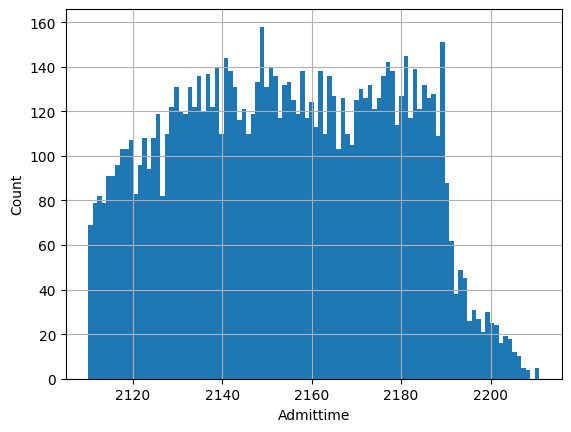

In [10]:
df.admittime.hist(bins=100)
plt.xlabel('Admittime')
plt.ylabel('Count')
plt.show()

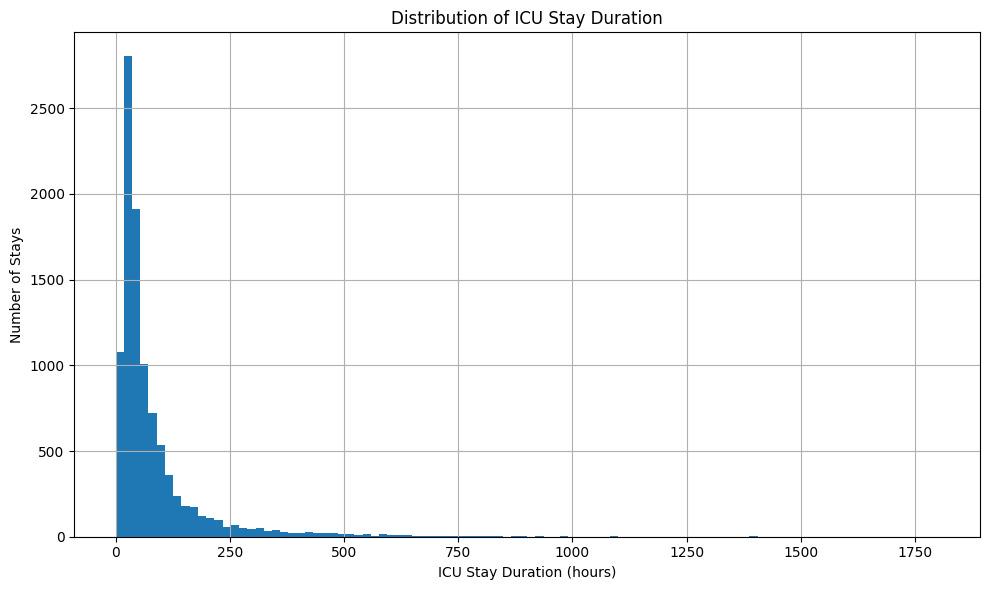

In [11]:
# Convert timedelta to hours (or use .dt.days for days)
df['length_of_icu_stay_hours'] = df['length_of_icu_stay'].dt.total_seconds() / 3600

plt.figure(figsize=(10, 6))
df['length_of_icu_stay_hours'].hist(bins=100)
plt.xlabel('ICU Stay Duration (hours)')
plt.ylabel('Number of Stays')
plt.title('Distribution of ICU Stay Duration')
plt.tight_layout()
plt.show()


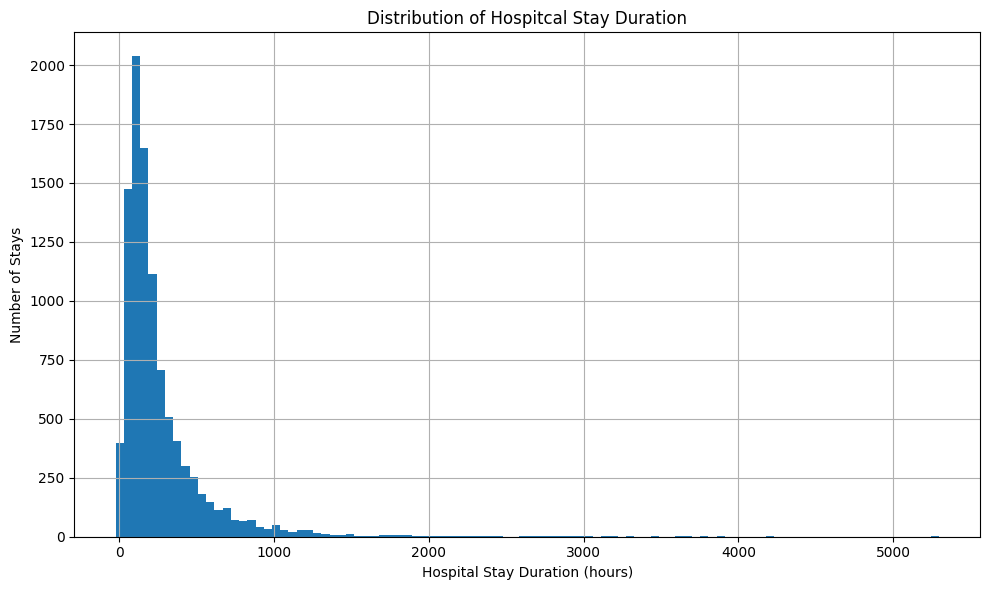

In [12]:
# Convert timedelta to hours (or use .dt.days for days)
df['admit_to_disch_hours'] = df['admit_to_disch'].dt.total_seconds() / 3600

plt.figure(figsize=(10, 6))
df['admit_to_disch_hours'].hist(bins=100)
plt.xlabel('Hospital Stay Duration (hours)')
plt.ylabel('Number of Stays')
plt.title('Distribution of Hospitcal Stay Duration')
plt.tight_layout()
plt.show()

These plots show that the majority of hospital and ICU stays are relatively short, with most ICU stays lasting under 200 hours (~8 days) and hospital stays under 500 hours (~20 days). Both distributions are highly right-skewed, indicating that a small number of patients experienced significantly longer stays. The frequency drops sharply as the duration increases, with a few outliers extending well beyond 1,000 hours.

# 4. Text Data EDA

## 4.1 Basic statistics

In [13]:
df['note_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

In [14]:
df[['note_length','word_count']].head()

,note_length,word_count
0,8163,1254
1,18083,2611
2,13566,2058
3,14745,2143
4,10078,1576


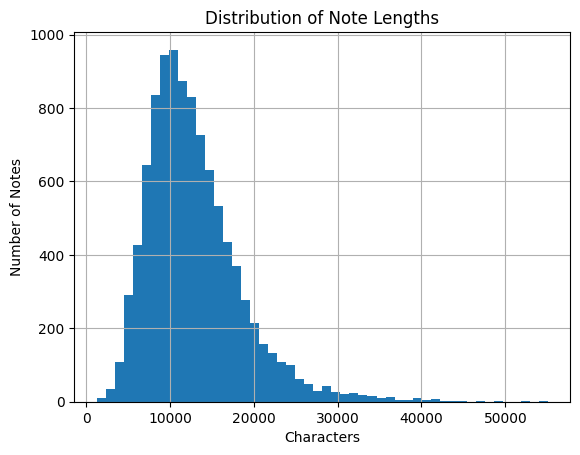

In [15]:
# Histogram
df['note_length'].hist(bins=50)
plt.title("Distribution of Note Lengths")
plt.xlabel("Characters")
plt.ylabel("Number of Notes")
plt.show()

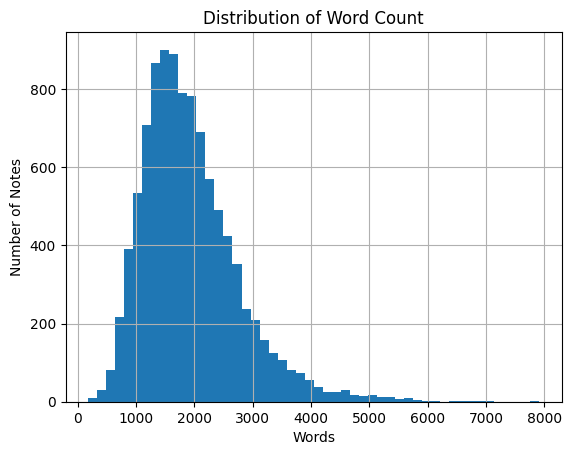

In [16]:
# Histogram
df['word_count'].hist(bins=50)
plt.title("Distribution of Word Count")
plt.xlabel("Words")
plt.ylabel("Number of Notes")
plt.show()

## 4.2 Check for duplicates

In [17]:
# check for duplicate discharge notes for the same patient (subject_id) and hospital admission (hadm_id).
df.duplicated(subset=['subject_id', 'hadm_id', 'text']).sum()


146

In [18]:
dup_df = df[df.duplicated(subset=['subject_id', 'hadm_id', 'text'], keep=False)]
dup_df = dup_df.sort_values(by=['subject_id', 'hadm_id'])
dup_df.head()

,subject_id,hadm_id,stay_id,admittime,dischtime,intime,outtime,note_id,text,length_of_icu_stay,admit_to_disch,length_of_icu_stay_hours,admit_to_disch_hours,note_length,word_count
6181,10097612,21981172,38728878,2159-11-11 23:17:00,2159-11-27 17:30:00,2159-11-21 16:53:01,2159-11-23 21:31:07,10097612-DS-18,\nName: ___ Unit No: __...,2 days 04:38:06,15 days 18:13:00,52.635000,378.216667,11669,1808
8784,10097612,21981172,37784017,2159-11-11 23:17:00,2159-11-27 17:30:00,2159-11-15 10:14:06,2159-11-16 18:04:54,10097612-DS-18,\nName: ___ Unit No: __...,1 days 07:50:48,15 days 18:13:00,31.846667,378.216667,11669,1808
91,10098215,21701015,36587540,2118-01-10 03:42:00,2118-02-13 19:00:00,2118-01-29 08:34:28,2118-01-31 21:26:32,10098215-DS-17,\nName: ___ Unit No: ___...,2 days 12:52:04,34 days 15:18:00,60.867778,831.300000,21988,3289
7703,10098215,21701015,30598744,2118-01-10 03:42:00,2118-02-13 19:00:00,2118-01-10 12:52:08,2118-01-14 18:43:50,10098215-DS-17,\nName: ___ Unit No: ___...,4 days 05:51:42,34 days 15:18:00,101.861667,831.300000,21988,3289
5616,10108435,22063907,39659709,2184-03-04 21:58:00,2184-03-26 21:00:00,2184-03-04 23:56:00,2184-03-09 01:24:56,10108435-DS-32,\nName: ___ ___ No: ___\n \nAdmis...,4 days 01:28:56,21 days 23:02:00,97.482222,527.033333,10423,1600


In [19]:
# for (subject, hadm), group in dup_df.groupby(['subject_id', 'hadm_id']):
#     print(f"\n🔹 subject_id: {subject}, hadm_id: {hadm}, count: {len(group)}")
#     display(group)

After run the code cell above to inspect the duplicates within each group, it appears that the duplicated records correspond to different ICU stay_ids for the same patient within the same hadm_id. Most groups have two distinct stay_ids, while a few have three. 

## 4.3 Frequent words or terms

In [20]:
# Loads a list of common English stopwords (e.g., "the", "is", "and") using nltk and converts it to a set for faster lookup
# Base stopwords
stop_words = set(stopwords.words('english'))

def tokenize(text):
    # Lowercase and tokenize using regex
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [word for word in tokens if word not in stop_words and word not in string.punctuation]

# .explode() flattens the list into a single column of words, one per row — so now all_words is a Series of individual words across all notes.
all_words = df['text'].apply(tokenize).explode() 

# Count the frequency of each word in the exploded Series using Counter, and returns the 20 most common words as a list of tuples (word, count)
Counter(all_words).most_common(20)

[('___', 725513),
 ('1', 200562),
 ('mg', 178274),
 ('2', 165674),
 ('po', 146863),
 ('blood', 137494),
 ('0', 125808),
 ('3', 122982),
 ('5', 113304),
 ('4', 105429),
 ('daily', 104594),
 ('patient', 97496),
 ('discharge', 92316),
 ('left', 82974),
 ('tablet', 74974),
 ('6', 73352),
 ('8', 72465),
 ('right', 72057),
 ('7', 70421),
 ('history', 64437)]

'mg', 'tablet', and numbers like '1', '2' are common — expected in medication instructions. 'patient', 'discharge', 'history' are frequent medical terms in discharge summaries.
To improve quality:
1. add '__', digits ('1', '2'...), and 'mg', 'tablet' to a custom stopword list since they aren't meaningful for modeling, 
2. apply POS-aware lemmatization (reduce "patients" to "patient", "was" to "be") for better generalization and accuracy.

## 4.4 Text Precessing (Cleaning, Tokenization and Lemmatization)

### 4.4.1 NLTK Based Pipeline (in python loops, slowest)

In [21]:
# Step 1: Stopword setup
# Base stopwords
stop_words = set(stopwords.words('english'))

# Add custom stopwords
custom_stopwords = {
    '__', '___', '____', 'mg', 'tablet', 'po', 'x', 'bid', 'prn' 
}

# Merge with base stopwords
stop_words.update(custom_stopwords)

# Step 2: POS (part-of-speech) tag mapping for WordNetLemmatizer
def get_wordnet_pos(treebank_tag):
    """The POS tags returned by nltk.pos_tag() (called Treebank tags) are different from the format expected by WordNetLemmatizer, 
    this function is to convert Treebank POS tags to the format WordNet understands """
    """Map NLTK POS tag to WordNet POS tag."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Step 3: Tokenizer function with POS-based lemmatization
def clean_tokenize(text):
    # Lowercase and tokenize
    tokens = word_tokenize(text.lower())
    # POS tagging
    pos_tags = pos_tag(tokens)
    
    # Lemmatize with POS, remove stopwords/punctuation
    clean_tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tags
        if word not in stop_words and word not in string.punctuation and not word.isdigit()
    ]
    return clean_tokens

# Step 4: Apply with progress bar, Apply to dataframe
tqdm.pandas()
df['nltk_clean_token'] = df['text'].progress_apply(clean_tokenize)


100%|██████████| 10000/10000 [21:11<00:00,  7.87it/s]


It took 21min.

The above code took more than 16min...
I switched to a  speed-optimized version of NLP pipeline with:
- Efficient preprocessing
- POS-aware lemmatization
- No compromise on accuracy or generalization
- Optional parallelization (safe for pandas)
- Progress tracking via tqdm

### 4.4.2 spaCy-based improved pipeline
- Uses compiled Cython code under the hood
- Runs tokenization, POS tagging, and lemmatization in a single pass
- Allows disabling unused components (e.g., parser, ner) to speed up further

In [22]:
# Step 1: Install dependencies (once)
#! python -m spacy download en_core_web_sm

# Step 2: Optimized Pipeline Using spaCy
# Load spaCy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Define stopwords and digits to remove
nltk_stopwords = set(stopwords.words('english'))
custom_stopwords = nltk_stopwords.union({'___', '__', '____', 'mg', 'tablet', 'po', 'x', 'bid', 'prn'})
punctuations = set(string.punctuation)

# Tokenizer + POS Lemmatizer
def spacy_clean_tokenize(text):
    doc = nlp(text.lower())
    return [
        token.lemma_
        for token in doc
        if token.is_alpha                            # keep only alphabetic tokens
        and token.text not in custom_stopwords       # remove stopwords + custom
        and not token.text.isdigit()                 # remove numbers
    ]

# Step 3: Apply with progress bar
tqdm.pandas()
df['spacy_clean_token'] = df['text'].progress_apply(spacy_clean_tokenize)

100%|██████████| 10000/10000 [57:50<00:00,  2.88it/s]   


It took 31min.

### 4.4.3 Ultra-Fast spaCy Pipeline (Batch Processing)
process multiple notes in batches — much faster than applying function one note at a time.
Why this is fastest:
- nlp.pipe() processes batches of texts internally with compiled code
- avoid Python-level function calls per row (big slowdown in pandas)
- spaCy is Vectorized
- spaCy uses CPU cores efficiently
- tqdm still tracks without slowing execution

In [ ]:
# Step 1: Code — Fast batched lemmatization with nlp.pipe()

# Load spaCy with only what we need
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Prepare stopwords and punctuation
nltk_stopwords = set(stopwords.words('english'))
custom_stopwords = nltk_stopwords.union({'__', '___', '____', 'mg', 'tablet', 'po', 'x', 'bid', 'prn'})
punctuations = set(string.punctuation)

# ---------- Fast batch processing ----------
def spacy_tokenizer_pipe(texts, batch_size=1000):
    """Yields token lists for each doc using spaCy's fast pipe processing"""
    for doc in nlp.pipe(texts, batch_size=batch_size):
        yield [
            token.lemma_.lower() for token in doc
            if token.is_alpha
            and token.text.lower() not in custom_stopwords
            and not token.text.isdigit()
        ]

# Step 2: Avoid loading all at once. Instead, use a loop and process in mini-batches

results = []
batch_size = 200  # smaller batch size to avoid memory issues

for i in range(0, len(df), batch_size):
    print(f"Processing batch {i // batch_size + 1} / {(len(df) + batch_size - 1) // batch_size}")
    batch_texts = df['text'][i:i+batch_size].fillna('')
    tokens = list(spacy_tokenizer_pipe(batch_texts))
    results.extend(tokens)

df['batch_spacy_clean_token'] = results

Processing batch 1 / 50
Processing batch 2 / 50
Processing batch 3 / 50
Processing batch 4 / 50
Processing batch 5 / 50
Processing batch 6 / 50
Processing batch 7 / 50
Processing batch 8 / 50
Processing batch 9 / 50
Processing batch 10 / 50
Processing batch 11 / 50
Processing batch 12 / 50
Processing batch 13 / 50
Processing batch 14 / 50
Processing batch 15 / 50
Processing batch 16 / 50
Processing batch 17 / 50
Processing batch 18 / 50
Processing batch 19 / 50
Processing batch 20 / 50
Processing batch 21 / 50
Processing batch 22 / 50
Processing batch 23 / 50
Processing batch 24 / 50
Processing batch 25 / 50
Processing batch 26 / 50
Processing batch 27 / 50
Processing batch 28 / 50
Processing batch 29 / 50
Processing batch 30 / 50
Processing batch 31 / 50
Processing batch 32 / 50
Processing batch 33 / 50
Processing batch 34 / 50
Processing batch 35 / 50
Processing batch 36 / 50
Processing batch 37 / 50
Processing batch 38 / 50
Processing batch 39 / 50
Processing batch 40 / 50
Processin

It took 45min time long. 

### 4.4.4 Save Dataset and Variables

Save df DataFrame into csv file

In [24]:
# Get the current working directory
current_dir = os.getcwd()

# Create the full path
folder_path = os.path.join(current_dir, 'Saved_Datasets')

# Save to csv file
df.to_csv(os.path.join(folder_path, "cleaned_tokens.csv"), index=False)

Save only selected important variables

In [38]:
session_data = {
    'df': df                         # cleaned DataFrame
}

joblib.dump(session_data, 'Saved_Datasets/cleaned_tokens_session.joblib')

['Saved_Datasets/cleaned_tokens_session.joblib']

Resuming work

In [37]:
# import joblib
# import pandas as pd
# session_data = joblib.load("Saved_Datasets/cleaned_tokens_session.joblib")
# df = session_data['df]

### 4.4.5 Choose the best pipeline

In [40]:
df = df.drop(columns='text')

In [ ]:
df['nltk_token_n'] = df['nltk_clean_token'].apply(len)
df['spacy_token_n'] = df['spacy_clean_token'].apply(len)
df['batch_spacy_token_n'] = df['batch_spacy_clean_token'].apply(len)

In [43]:
df[['nltk_token_n', 'spacy_token_n', 'batch_spacy_token_n']].head(10)

,nltk_token_n,spacy_token_n,batch_spacy_token_n
0,785,730,730
1,1846,1578,1575
2,1272,1163,1160
3,1378,1195,1191
4,958,887,887
5,1391,1277,1272
6,874,797,795
7,859,766,765
8,1660,1415,1415
9,632,566,562


Compared to the NLTK-based pipeline, the spaCy-based pipeline produces a lower token count per text document after cleaning, tokenization, and lemmatization. This reduction may indicate better removal of noise or redundancy, which could be beneficial for downstream processes such as TF-IDF, potentially leading to improved generalization. However, before making a final decision, I will identify and display pipeline-specific tokens (i.e., tokens unique to each pipeline, excluding those shared by all three).

In [49]:
def pipeline_specific_tokens(row):
    set1, set2, set3 = set(row['nltk_clean_token']), set(row['spacy_clean_token']), set(row['batch_spacy_clean_token'])
    
    shared = set1 & set2 & set3  # Tokens shared by all three
    
    return {
        'unique_nltk': list(set1 - shared),
        'unique_spacy': list(set2 - shared),
        'unique_batch_spacy': list(set3 - shared)
    }

# Apply the function row-wise
unique_tokens_df = df.iloc[:2].apply(pipeline_specific_tokens, axis=1, result_type='expand')

In [50]:
# Set display options to avoid truncation
pd.set_option('display.max_colwidth', None)       # No limit on column content width
pd.set_option('display.width', 0)                 # Auto-detect the width of the display
pd.set_option('display.max_columns', None)        # Show all columns

In [51]:
display(unique_tokens_df)

,unique_nltk,unique_spacy,unique_batch_spacy
0,"[x2, pedis, myalgia, d/c, s/p, pfts, 125mg, dishelved, 2+, documented, 1.2, ox3, extremity, 1g, q6h, desaturations, 7.39/47/66, pending, 6.2, 4:15pm, vs., disp, 4., '', .01, felt, copd/asthma, n't, ``, rashes/lesions, 5., em, 2., anxiety/psychiatric, 7., o2sat, b0.6, 9., woke, q12h, mcg/actuation, 10., 6., asthma/copd, 's, rr60, 11., mcg/dose, refill, 1., o2, 102/66, copd/emphysema, attend, 8., 750mg, x1, vomit, suggests, 250-50, l30.8, sustain, n61.8, s2, v, w/inhalation, e2.3, 141/77, h, vitals, known, 650mg, arthralgias, /4l, wander, prescribed, nabs, cns, abdomen, m4.5, 127/82, 3., fluticasone-salmeterol, continued, p/w, 8.6, 98.0, 41.4, confirmed, 97.2, s1]","[g, confirm, pedi, abdoman, hs, desaturation, wandering, cns, asthma, vs, vital, w, attend, lesion, prescribe, hyperexpande, dishelve, wake, document, extremity, sustain, fluticasone, actuation, c, pende, p, vomiting, salmeterol, nab, pft, myalgias, feel, rash, ems, arthralgia]","[sustained, known, g, confirm, pedi, hs, desaturation, cn, wandering, nabs, attending, abdomen, extremitie, asthma, vs, vital, w, systems, lesion, prescribe, hyperexpande, dishelve, wake, document, fluticasone, actuation, c, pende, instructions, p, vomiting, salmeterol, pft, myalgias, feel, rash, ems, arthralgia]"
1,"[absmono-0.89, 20., gap-23, 05:56am, 3.5, units/ml, monos-4.5, co2-22, hba1c-6.8, piperacillin/tazo, hct-40.8, confirm, na-132, myalgia, lymphs-2.8, pco2-51, mchc-32.6, 05:45am, 23., ascites, -hld, target, s/p, 13., non-distended, required, 10:24am, ==================, 28qhs, --, 19., 1.00e+08, stain-final, lactate-2.8, abseos-0.02, -thrombectomy, chloride-94, drawn, delayed, -25, rdw-18.9, lumen, follow-up, 20,000, ox3, 4.5mg, -___, 26., q6h, tip-to-cuff, c-folic, 27., hgb-10.7, sgot, 50,000, 4u, 68/43, 12., cl-92, 14., 22., 17., bili-0.4, tricyclic-neg, dm2, 1990s, tobramycin, 2.8., -excision, sgpt, 4., eos-0.1, trf-164, 3.5mg, best, n't, basos-0.5, 10mg, mch-25.1, rashes/lesions, 5., 06:06pm, mcv-75, calcium-7.4, extend, trimethoprim/sulfa, neuts-91.2, 15., =0.25, w/meals, 2., mcv-78, copies/ul, duplicated, denies, 0.8, rbc-5.25, glucose-135, orient, ast, ...]","[acetmnphn, study, trimethoprim, imaging, tazobactam, extend, neg, min, sa, satte, arthralgias, clearing, target, ascite, club, tricyclic, marcescen, defervesced, dm, piperacillin, iu, vital, attend, vs, mr, anticoagulate, eye, luman, folic, draw, barbitrt, pan, meal, duplicate, tender, gnrs, wheezing, good, ethanol, nephrocap, vite, oriented, correct, distended, c, bnzodzpn, pende, necessitating, nephro, p, datum, reaction, confirmed, ul, complex, vanc, vomiting, n, myalgias, copy, clotting, we, non]","[acetmnphn, known, allergies, trimethoprim, im, imaging, tazobactam, neg, sa, veins, satte, clearing, targeted, denies, reactions, ascite, club, tricyclic, attending, defervesced, piperacillin, iu, vs, vital, studies, anticoagulate, labs, luman, meals, folic, draw, antibiotics, pan, extended, barbitrt, duplicate, id, tender, wheezing, performed, nephrocaps, good, ethanol, marcescens, vite, lower, oriented, distended, c, bnzodzpn, eyes, instructions, pende, necessitating, nephro, sliding, datum, p, confirmed, ul, complex, vanc, vomiting, mins, gnr, us, corrected, ns, myalgias, copy, clotting, arthralgia, non, issues]"


The NLTK-based pipeline produces noisy tokens such as digits, equal signs ('='), underscores ('_'), and dashes ('--'), which are unlikely to contribute meaningful information for predicting hospital readmission. In contrast, both spaCy-based pipelines generate much cleaner and more semantically relevant tokens. Given their comparable output quality and the fact that the batch spaCy pipeline is significantly faster, I will proceed with the tokens generated by the batch spaCy pipeline for downstream modeling.

## 4.5 Text Feature Extraction

Extract TF-IDF features from your selected token column (e.g., 'batch_spacy_clean_token')

In [ ]:
# 1. Join token lists into strings (required by TfidfVectorizer)
df['token_text'] = df['batch_spacy_clean_token'].apply(lambda tokens: ' '.join(tokens))

# 2. Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    lowercase=False,   # Tokens are already cleaned
    max_features=1000, # Adjust as needed
    ngram_range=(1, 2) # Unigrams and bigrams
)

# 3. Fit and transform
X_tfidf = tfidf_vectorizer.fit_transform(df['token_text'])

# 4. Convert to DataFrame for inspection

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df.shape


(10000, 1000)

In [64]:
tfidf_df.head()

,abd,abd soft,abdoman,abdomen,abdomen soft,abdominal,abdominal pain,able,abnormal,abnormality,abscess,abuse,accurate,accurate complete,acetaminophen,acetaminophen pain,acid,active,activity,activity status,acute,acute distress,additional,admission,admission date,admission labs,admission physical,admission preadmission,admit,adverse,adverse drug,afebrile,afib,age,ago,air,airway,albuterol,alcohol,alert,alert interactive,alert orient,allergies,allergies adverse,allergy,allergy known,along,also,although,ambulate,ambulatory,ambulatory independent,amiodarone,amlodipine,amount,anemia,aneurysm,anicteric,anterior,antibiotic,anticoagulation,anxiety,aorta,aortic,aortic regurgitation,aortic stenosis,aortic valve,appear,appointment,appropriate,approximately,area,arm,around,arrival,artery,artery disease,artery systolic,asa,ascite,aspiration,aspirin,aspirin daily,assess,assistance,associate,atelectasis,atorvastatin,atrial,atrial fibrillation,atrium,attempt,attending,attending chief,avoid,awake,back,base,baseline,become,bed,bedtime,begin,bilateral,bilaterally,biopsy,birth,birth sex,bladder,bleed,bleeding,blood,blood blood,blood ck,blood culture,blood plt,blood pressure,body,bone,bowel,bowel sound,bp,brain,breath,breathing,brief,brief hospital,bring,bypass,cabg,cad,calcium,call,cancer,capsule,capsule sig,cardiac,cardiology,care,care facility,carotid,cath,catheter,catheterization,cause,cavity,cavity size,cefepime,cell,central,cervical,chamber,chamber size,change,check,chest,chest pain,chest tube,chf,chief,chief complaint,chill,chloride,chronic,cirrhosis,ck,clear,clear coherent,clinic,clinical,close,clot,club,cm,code,coherent,coherent level,collection,colon,color,come,command,common,compare,complaint,complete,complicate,complication,concern,condition,condition mental,confirm,consciousness,consciousness alert,consider,consistent,consolidation,constipation,consult,contact,continue,continue home,contrast,control,copd,coronary,coronary artery,cough,could,coumadin,count,course,cr,crackle,creatinine,ct,ct head,cta,culture,culture final,currently,cv,cxr,cyanosis,daily,daily daily,daily discharge,daily disp,daily rx,date,date birth,date date,date discharge,day,day discharge,day disp,dear,decrease,deep,defect,delayed,delayed release,demonstrate,denies,deny,depression,describe,detail,develop,diabetes,diagnosis,diagnosis primary,dialysis,diameter,diarrhea,diastolic,die,diet,difficulty,diffuse,dilate,direct,discharge,discharge condition,discharge date,discharge diagnosis,discharge disposition,discharge home,discharge instruction,discharge labs,discharge medication,discontinue,discuss,discussion,disease,disorder,disp,disposition,disposition extended,disposition home,distal,distended,distress,diuresis,dm,do,doctor,docusate,docusate sodium,doppler,dose,dp,drain,drainage,drink,drip,drive,drop,drug,drug reactions,dry,due,duration,dvt,dysfunction,dyspnea,early,echo,ed,edema,eeg,ef,effect,effusion,egd,ekg,elevate,elevated,elevation,emergency,encephalopathy,end,eomi,episode,erythema,etiology,etoh,evaluate,evaluation,every,every hour,evidence,exam,exam admission,exam vital,examination,exclude,experience,expire,ext,ext warm,extended,extended care,extensive,extremity,extubate,eye,face,facial,facility,facility discharge,failure,fall,family,family history,father,feel,female,femoral,fever,fever chill,fibrillation,field,final,final report,find,finding,first,floor,flow,fluid,focal,foley,follow,follow appointment,followup,followup instructions,foot,four,fracture,free,free wall,frontal,full,function,furosemide,gabapentin,gallop,gen,general,get,gi,give,global,glucose,go,goal,good,grade,graft,gram,gram stain,great,grossly,growth,gtt,hct,hd,head,headache,heal,heart,heart failure,heent,help,hematoma,hemodynamically,hemorrhage,heparin,hepatic,hernia,high,hip,history,history family,history present,hold,home,home service,hospital,hospital course,hospitalization,hour,hour need,however,hr,hr bp,hs,htn,hx,hyperlipidemia,hypertension,hypertrophy,hypokinesis,hypotension,icu,identify,ih,i